In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
import sklearn.model_selection as skm

import plotly.graph_objects as go


In [51]:
#import
df=pd.read_excel("synthesized_data.xlsx")
df=df[df['batch_id'].astype(str).str.startswith('S1')]
df.head()

,batch_id,batch_time_h,titer_mg_mL,acetate_mM,glucose_g_L,mg_mM,nh3_mM,phosphate_mM
0,S1_syn_001,0,0.016667,44.156491,0.023141,11.821203,17.695473,12.888215
1,S1_syn_001,1,0.075776,52.151055,0.024878,11.855727,20.606514,14.132682
2,S1_syn_001,2,0.124705,59.551010,0.024873,11.908621,22.694492,15.016076
3,S1_syn_001,3,0.183994,63.674083,0.024147,11.761711,24.533753,15.429309
4,S1_syn_001,4,0.240574,67.732662,0.024206,11.837803,25.730974,16.153101


In [ ]:
#import batch level data
df_batch=pd.read_excel("batch_level_data.xlsx")
df_batch.head()

,batch_id,solution_type,Method,Site,titer_mg_mL
0,S1_syn_001,1,1,1,0.398551
1,S1_syn_002,1,1,1,0.445472
2,S1_syn_003,1,1,1,0.447912
3,S1_syn_004,1,1,1,0.446373
4,S1_syn_005,1,1,1,0.481636


## Level 1 (Observational) - Generate PLS Model from Data

In [ ]:
#define column roles, remove_titer to make df_model

meta_cols = ['batch_id']
time_cols = ['batch_time_h']
output_cols = ['titer_mg_mL']

#define y column, time in this case
y_col=['batch_time_h']
y=df[y_col]
print("y shape:", y.shape)


#define columns
X_cols=['acetate_mM', 'glucose_g_L', 'mg_mM','nh3_mM', 'phosphate_mM']
df_model = df[time_cols+ meta_cols + X_cols].copy()
df_model = df_model.sort_values(['batch_id', 'batch_time_h'])  # sort for consistent time ordering
df_model.head()


y shape: (425, 1)


,batch_time_h,batch_id,acetate_mM,glucose_g_L,mg_mM,nh3_mM,phosphate_mM
0,0,S1_syn_001,44.156491,0.023141,11.821203,17.695473,12.888215
1,1,S1_syn_001,52.151055,0.024878,11.855727,20.606514,14.132682
2,2,S1_syn_001,59.551010,0.024873,11.908621,22.694492,15.016076
3,3,S1_syn_001,63.674083,0.024147,11.761711,24.533753,15.429309
4,4,S1_syn_001,67.732662,0.024206,11.837803,25.730974,16.153101


X shape: (425, 5)


C:\Users\jhuang\AppData\Local\Temp\ipykernel_21016\2510219239.py:29: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



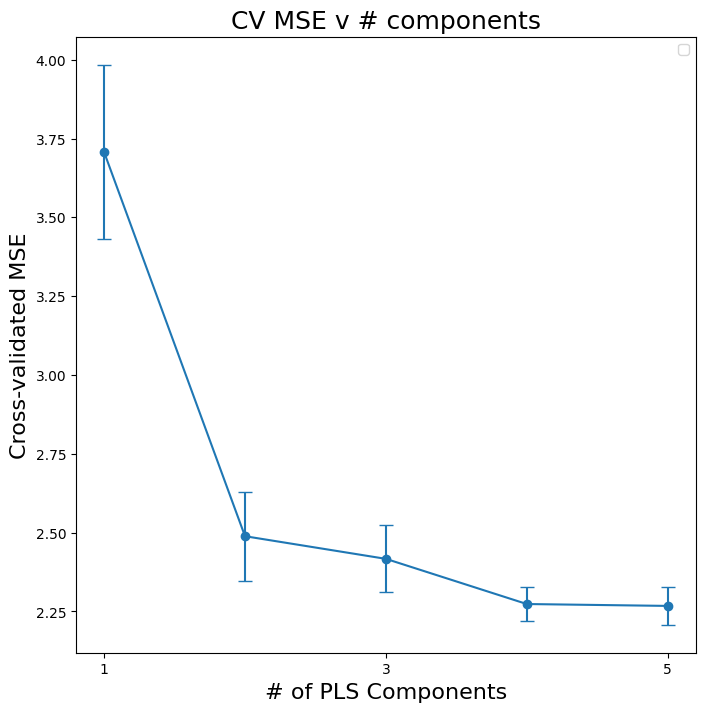

In [57]:
#train PLS model, choose number of components using CV

X=np.array(df_model[X_cols])
print("X shape:", X.shape)
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

K = 5
kfold = skm.KFold(K,random_state=0,shuffle=True)

pls = PLSRegression()

param_grid = {'n_components':range(1, len(X_cols)+1)}
grid = skm.GridSearchCV(pls ,param_grid ,cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X_scaled, y)

# Extract results
mean_mse = -grid.cv_results_['mean_test_score']
std_mse = grid.cv_results_['std_test_score'] / np.sqrt(K)
optimal_n_components = grid.best_params_['n_components']

# Plot Cross-Validated MSE vs. # of PLS Components
plt.figure(figsize=(8, 8))
plt.errorbar(param_grid['n_components'], mean_mse, yerr=std_mse, fmt='o-', capsize=5)
plt.ylabel("Cross-validated MSE", fontsize=16)
plt.xlabel("# of PLS Components", fontsize=16)
plt.xticks(list(param_grid['n_components'])[::2])  # Show every other tick
plt.title("CV MSE v # components", fontsize=18)
plt.legend()
plt.show()

In [ ]:
#get T matrix, scores, (NxJ)xA
n_comp = 2
pls_1 = PLSRegression(n_components=n_comp)
pls_1.fit(X_scaled, y)
T = pls_1.transform(X_scaled) 
print(T.shape)

(425, 2)


In [ ]:
#generate pls_score_df with labels for batch id and tim

score_cols = [f"comp_{i+1}" for i in range(n_comp)]

T_df = pd.DataFrame(T, columns=score_cols, index=df_model.index)

pls_scores_df = pd.concat(
    [df_model[time_cols+meta_cols].reset_index(drop=True),
     T_df.reset_index(drop=True)],
    axis=1
)
pls_scores_df.head()

,batch_time_h,batch_id,comp_1,comp_2
0,0,S1_syn_001,-1.747582,-2.294482
1,1,S1_syn_001,-1.595890,-1.593405
2,2,S1_syn_001,-1.532687,-0.999043
3,3,S1_syn_001,-1.454071,-0.669697
4,4,S1_syn_001,-1.449703,-0.285240


## Part 2 - Batch Evolution Modeling

In [ ]:
#reorganize matrix to  Nx(AxJ) via melt and pivot
def make_batch_level_matrix_pandas(pls_scores_df,
                                   batch_col='batch_id',
                                   time_col='batch_time_h',
                                   comp_prefix='comp_'):
    # 1) find component columns
    comp_cols = [c for c in pls_scores_df.columns if c.startswith(comp_prefix)]

    # 2) melt to long: one row per (batch, time, component)
    long = pls_scores_df.melt(
        id_vars=[batch_col, time_col],
        value_vars=comp_cols,
        var_name='component',
        value_name='score'
    )

    # 3) pivot: rows = batch, columns = (component, time)
    wide = (
        long
        .pivot(index=batch_col, columns=['component', time_col], values='score')
        .sort_index(axis=1, level=[0, 1])
    )

    # 4) optionally flatten MultiIndex columns -> comp_1_0.0, comp_1_1.0, ...
    wide.columns = [f"{comp}_{t}" for (comp, t) in wide.columns]

    return wide
X_T_df = make_batch_level_matrix_pandas(pls_scores_df)
print(X_T_df.shape)   # N x (A*J)
print(X_T_df.head())

(17, 50)
            comp_1_0  comp_1_1  comp_1_2  comp_1_3  comp_1_4  comp_1_5  \
batch_id                                                                 
S1_syn_001 -1.747582 -1.595890 -1.532687 -1.454071 -1.449703 -1.415352   
S1_syn_002 -2.108664 -2.139138 -2.111507 -2.200045 -2.191990 -2.164709   
S1_syn_003 -2.116204 -2.162861 -2.049186 -2.146566 -2.030741 -1.993775   
S1_syn_004 -1.482896 -1.446559 -1.446904 -1.490590 -1.522649 -1.304107   
S1_syn_005 -2.669822 -2.492182 -2.418752 -2.176700 -2.041409 -1.835693   

            comp_1_6  comp_1_7  comp_1_8  comp_1_9  ...  comp_2_15  comp_2_16  \
batch_id                                            ...                         
S1_syn_001 -1.228802 -1.245147 -1.035664 -0.816495  ...  -0.308307  -0.330485   
S1_syn_002 -1.985662 -1.859208 -1.578412 -1.492036  ...   0.239271   0.076749   
S1_syn_003 -1.639242 -1.515866 -1.370681 -1.360451  ...   1.157124   0.894327   
S1_syn_004 -1.078282 -0.778784 -0.844721 -0.442547  ...  -0.480407 

In [ ]:
#calculate average, standard deviations for each column.
#calculate upper and lower limits

mean_row=X_T_df.mean(axis=0)
std_row=X_T_df.std(axis=0)
upper_limit_row=mean_row+3*std_row
lower_limit_row=mean_row-3*std_row

summary_df = pd.DataFrame(
    [mean_row, std_row, upper_limit_row, lower_limit_row],
    index=['mean', 'std', 'upper_3sd','lower_3sd']
)

X_T_with_stats = pd.concat([X_T_df, summary_df], axis=0)
print(X_T_with_stats.tail())


            comp_1_0  comp_1_1  comp_1_2  comp_1_3  comp_1_4  comp_1_5  \
S1_syn_017 -2.530839 -2.427321 -2.378374 -2.181016 -2.090589 -2.032885   
mean       -1.935981 -1.904058 -1.892709 -1.844247 -1.769698 -1.651286   
std         0.447914  0.414205  0.395207  0.373841  0.396682  0.398060   
upper_3sd  -0.592240 -0.661442 -0.707088 -0.722723 -0.579652 -0.457105   
lower_3sd  -3.279723 -3.146674 -3.078330 -2.965770 -2.959744 -2.845467   

            comp_1_6  comp_1_7  comp_1_8  comp_1_9  ...  comp_2_15  comp_2_16  \
S1_syn_017 -1.734801 -1.690426 -1.415786 -1.030434  ...   0.133352  -0.182678   
mean       -1.518404 -1.331187 -1.131952 -0.968836  ...   0.346797   0.209125   
std         0.354192  0.374279  0.329528  0.360337  ...   0.553392   0.514404   
upper_3sd  -0.455827 -0.208351 -0.143369  0.112176  ...   2.006973   1.752336   
lower_3sd  -2.580980 -2.454023 -2.120534 -2.049848  ...  -1.313379  -1.334086   

            comp_2_17  comp_2_18  comp_2_19  comp_2_20  comp_2_21  c

In [ ]:
#Visualize

def plot_component_with_bounds(X_T_df, component='comp_1'):
    """
    Plot a selected PLS component for each batch over time, plus mean ± 3*SD bounds.

    Parameters
    ----------
    X_T_df : pd.DataFrame
        Rows = batches (and possibly summary rows like 'mean', 'std', etc.).
        Columns = features like 'comp_1_t0.0', 'comp_1_t1.0', ...
    component : str, default 'comp_1'
        Which component to plot (prefix of column names).
    """

    # --- 1. Filter out any summary rows if they exist ---
    summary_labels = {'mean', 'std', 'upper_3sd', 'lower_3sd'}
    df_batches = X_T_df.loc[~X_T_df.index.isin(summary_labels)].copy()

    # --- 2. Select columns for the chosen component ---
    comp_cols = [c for c in df_batches.columns if c.startswith(component)]
    if not comp_cols:
        raise ValueError(f"No columns found for component '{component}'")

    # --- 3. Extract times from column names and sort ---
    def extract_time(col):
        # If your columns look like 'comp_1_t0.0':
        if '_t' in col:
            time_str = col.split('_t')[-1]
        else:
            # If instead you use 'comp_1_0.0', uncomment this line and adjust:
            # time_str = col.split(component)[-1].lstrip('_')
            time_str = col.split(component)[-1].lstrip('_')
        return float(time_str)

    times_and_cols = [(extract_time(c), c) for c in comp_cols]
    times_and_cols.sort(key=lambda x: x[0])
    times = [t for t, _ in times_and_cols]
    sorted_cols = [c for _, c in times_and_cols]

    # Subset in the correct time order
    comp_matrix = df_batches[sorted_cols]

    # --- 4. Compute bounds: mean ± 3*SD across batches for each timepoint ---
    mean_vals = comp_matrix.mean(axis=0)
    std_vals = comp_matrix.std(axis=0)
    upper_vals = mean_vals + 3 * std_vals
    lower_vals = mean_vals - 3 * std_vals

    # --- 5. Build Plotly figure ---
    fig = go.Figure()

    # Add one trace per batch
    for batch_id, row in comp_matrix.iterrows():
        fig.add_trace(
            go.Scatter(
                x=times,
                y=row.values,
                mode='lines',
                name=str(batch_id),
                hovertemplate='time: %{x}<br>score: %{y}<extra>' + str(batch_id) + '</extra>',
            )
        )

    # Add upper bound
    fig.add_trace(
        go.Scatter(
            x=times,
            y=upper_vals.values,
            mode='lines',
            name='upper (mean + 3·SD)',
            line=dict(dash='dot'),
            hovertemplate='time: %{x}<br>upper: %{y}<extra></extra>',
        )
    )

    # Add lower bound
    fig.add_trace(
        go.Scatter(
            x=times,
            y=lower_vals.values,
            mode='lines',
            name='lower (mean - 3·SD)',
            line=dict(dash='dot'),
            hovertemplate='time: %{x}<br>lower: %{y}<extra></extra>',
        )
    )

    fig.update_layout(
        title=f"{component} scores over time (per batch) with ±3·SD bounds",
        xaxis_title="Time (h)",
        yaxis_title=f"{component} score",
        legend_title="Batch / Bounds",
    )

    fig.show()
    return fig
# For component 1
plot_component_with_bounds(X_T_df, component='comp_1')

## Part 3 Batch Level Modeling

In [43]:
##join X_T_df with meta_cols and output_cols
df_combined=X_T_df.merge(df_batch, left_on='batch_id',right_on=['batch_id'])
df_combined.head()


,batch_id,comp_1_0,comp_1_1,comp_1_2,comp_1_3,comp_1_4,comp_1_5,comp_1_6,comp_1_7,comp_1_8,...,comp_2_19,comp_2_20,comp_2_21,comp_2_22,comp_2_23,comp_2_24,solution_type,Method,Site,titer_mg_mL
0,S1_syn_001,-1.747582,-1.595890,-1.532687,-1.454071,-1.449703,-1.415352,-1.228802,-1.245147,-1.035664,...,-0.482710,-0.688362,-0.711762,-0.752237,-0.839900,-0.731515,1,1,1,0.398551
1,S1_syn_002,-2.108664,-2.139138,-2.111507,-2.200045,-2.191990,-2.164709,-1.985662,-1.859208,-1.578412,...,-0.604945,-0.789453,-0.947076,-1.198413,-1.146850,-1.083822,1,1,1,0.445472
2,S1_syn_003,-2.116204,-2.162861,-2.049186,-2.146566,-2.030741,-1.993775,-1.639242,-1.515866,-1.370681,...,0.659416,0.538000,0.455988,0.582360,0.517225,0.584191,1,1,1,0.447912
3,S1_syn_004,-1.482896,-1.446559,-1.446904,-1.490590,-1.522649,-1.304107,-1.078282,-0.778784,-0.844721,...,-1.031844,-1.097241,-1.069145,-1.150643,-1.151901,-0.678923,1,1,1,0.446373
4,S1_syn_005,-2.669822,-2.492182,-2.418752,-2.176700,-2.041409,-1.835693,-1.841302,-1.588997,-1.326848,...,0.245282,0.012284,0.006833,-0.074625,-0.166262,-0.244833,1,1,1,0.481636


X shape: (17, 52)


C:\Users\jhuang\AppData\Local\Temp\ipykernel_21016\326824975.py:32: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



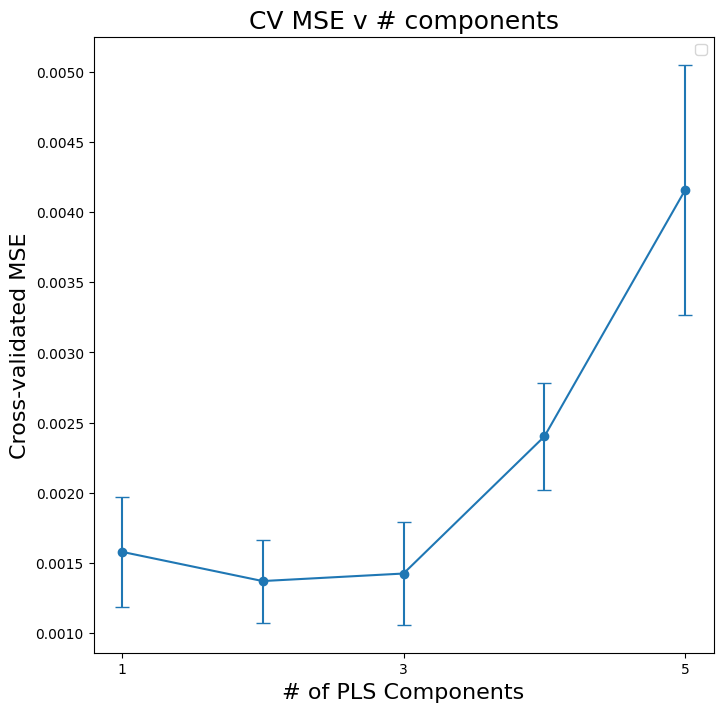

In [48]:
#PLS Model with X,Z stacked, predicting on Y
meta_cols=['batch_id','solution_type']
y_col=['titer_mg_mL']
exclude_cols=meta_cols+y_col
X=df_combined.drop(columns=exclude_cols).to_numpy()
y=df_combined[y_col]
print("X shape:", X.shape)
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

K = 5
kfold = skm.KFold(K,random_state=0,shuffle=True)

pls = PLSRegression()

param_grid = {'n_components':range(1, len(X_cols)+1)}
grid = skm.GridSearchCV(pls ,param_grid ,cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X_scaled, y)

# Extract results
mean_mse = -grid.cv_results_['mean_test_score']
std_mse = grid.cv_results_['std_test_score'] / np.sqrt(K)
optimal_n_components = grid.best_params_['n_components']

# Plot Cross-Validated MSE vs. # of PLS Components
plt.figure(figsize=(8, 8))
plt.errorbar(param_grid['n_components'], mean_mse, yerr=std_mse, fmt='o-', capsize=5)
plt.ylabel("Cross-validated MSE", fontsize=16)
plt.xlabel("# of PLS Components", fontsize=16)
plt.xticks(list(param_grid['n_components'])[::2])  # Show every other tick
plt.title("CV MSE v # components", fontsize=18)
plt.legend()
plt.show()

In [ ]:
#get T matrix, scores
n_comp = 2
pls_3 = PLSRegression(n_components=n_comp)
pls_3.fit(X_scaled, y)

### additional steps

Include 'deviation' batch

How to incorporate 2nd solution type

Include Time difference samples (interpolation?)

## Batch in Progress

In [ ]:

#load completed batches (good batches)
#generate df_model, and X
#select model n_componenents
#generate scores (T) through PLS_1
#convert to T_df
#Rearrange to X_T
#Calculate means and intervals.
#Plot

#load incomplete batch.
#generate df_model
#generate scores (T) through PLS_1.
#convert to T_df
#Rearrange to X_T
#Plot in conjunction to evaluate the BEM current.

